# 🧙 Create an evol-instruct dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/argilla-io/distilabel/blob/main/docs/tutorials/create-evol-instruct-dataset.ipynb) [![Open Source in Github](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/argilla-io/distilabel/blob/main/docs/tutorials/create-evol-instruct-dataset.ipynb)

In this tutorial, we'll develop an evol-instruct dataset by employing the approach outlined in ["WizardLM: Empowering Large Language Models to Follow Complex Instructions"](https://arxiv.org/pdf/2304.12244.pdf) using `distilabel` and `argilla`. In the next section, we will describe the process in detail. So, let's get started! 🪄

## Introduction

This paper proposes a new method, **Evol-Instruct**, to synthetically create a dataset with open-domain instructions of varying complexity using *gpt-3.5-turbo*. The resulting dataset, combined with the original, was used to fine-tune LLaMa, leading to the creation of WizardLM. This model surpasses ChatGPT in both human and automatic evaluations, demonstrating more than 90% of ChatGPT's capabilities in 17 out of 29 skills.

In this tutorial, we will only focus on the *Evol-Instruct* approach to create a more complex dataset. From an *initial dataset* that will be the seed for the evolution process, the steps for each epoch (determined as M=4) are as follows:

1. **Intruction Evolving**: Use *gpt-3.5-turbo* with predefined prompts to generate the evolved instructions. These prompts can be of two types: *in-depth evolving* (includes adding constraints, deepening, concretizing, increasing reasoning, and complicating the input) and *in-breath evolving* (includes mutation). The complicating prompt is the only one not applied as it needs in-context examples. Then, only one of the remaining five is selected randomly to be applied to the input instruction. You can check the original code [here](https://github.com/nlpxucan/WizardLM/tree/main/Evol_Instruct).
2. **Elimination Evolving**
   * The instruction evolving step may fail, so the new instructions are filtered according to the following criteria:
     1. The evolved instruction *does not provide any information* gain. Automatically evaluated with ChatGPT.
     2. The evolved instruction contains *"sorry" and is less than 80 words*.
     3. The evolved instruction only contains *punctuation and stop words*.
     4. The evolved instruction *copies words* from the evolving prompt.
   * If the evolved instruction passes the previous criteria, it is added to the pool of new instructions and also will be used as input for the next iteration. If not, it is dropped and the original instruction is the one used for the next iteration.

Once, the evolved instructions are generated, they use the same LLM to **generate the corresponding responses**.

Finally, the resulting dataset is the combination of the original and the new instructions generated in each epoch. In the next section, we will see how to implement this process using `distilabel` and `argilla`.

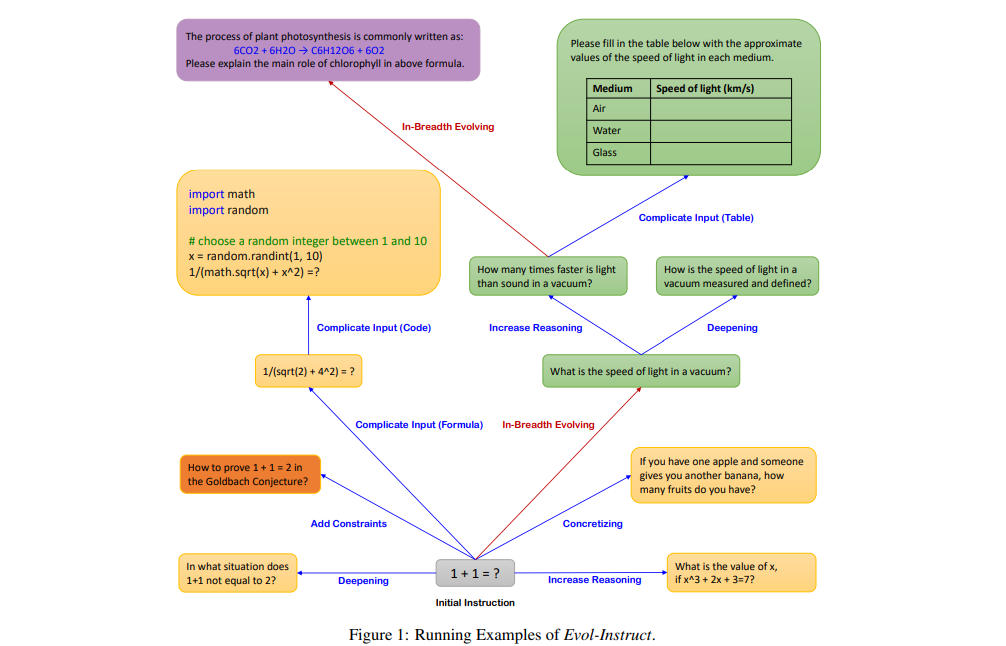

## Getting started

### Install dependencies

Let’s start by installing the required dependencies to run *distilabel*.

In [ ]:
%pip install -q -U "distilabel[openai]" --upgrade

Then we can import the required libraries.

In [1]:
import os
import string
import time
from dataclasses import dataclass
from typing import Dict, List

import argilla as rg
import pandas as pd
from datasets import Dataset, load_dataset

from distilabel.llm import LLM, OpenAILLM
from distilabel.pipeline import Pipeline
from distilabel.tasks import EvolInstructTask, Prompt, TextGenerationTask

### Environment variables

Finally, we will also need to provide some environment variables if they haven't been set already.

In [29]:
# OpenAI API Key
os.environ["OPENAI_API_KEY"] = 'sk-...'

# Argilla API Key
os.environ["ARGILLA_API_URL"] = "https://your-argilla-api-key"
os.environ["ARGILLA_API_KEY"] = "owner.apikey"

# HF Token
os.environ['HF_TOKEN'] = "hf_..."

## Prepare the initial dataset

The first step is to prepare the initial dataset that will be used for the evolution process. Following the same idea as shown in an example from the paper, we will use [camel-ai/math](https://huggingface.co/datasets/camel-ai/math) available in HuggingFace, a math dataset composed of 50K problem-solution pairs obtained using GPT-4. However, for the sake of this tutorial's example, we will only use 20 samples and the *message_1* column as input.

In [3]:
# Load the dataset
hf_dataset = load_dataset("camel-ai/math", split="train")

# Get our initial dataset
initial_dataset = (
    hf_dataset
    .select_columns(["message_1"])
    .rename_column("message_1", "input")
)

# Select a subset
initial_dataset = initial_dataset.shuffle(seed=5).select(range(3))

In [ ]:
# Load the dataset
hf_dataset = load_dataset("argilla/distilabel-intel-orca-dpo-pairs", split="train")

# Get our initial dataset
initial_dataset = (
    hf_dataset
    .select_columns(["input"])
)

# Select a subset
initial_dataset = initial_dataset.shuffle(seed=5).select(range(3))

In [4]:
initial_dataset

Dataset({
    features: ['input'],
    num_rows: 3
})

## Define our `LLM`s and `Tasks`

For our case, we will need to set two different LLMs with their corresponding tasks: one for the instruction evolving and another for the elimination evolving step 1.

### Instruction Evolving LLM

The first step is to define the LLM that will be used to generate the evolved instructions. According to the paper, we will use *gpt-3.5-turbo* as the language model, and the task `EvolInstructTask`, also we will set some parameters (Section 4.3). Take into account that the `EvolInstructTask` will perform the random selection of the evolving prompt and the filtering of the evolved instructions up the first step from the elimination evolving related to *equal prompts*.

In [5]:
# Define our LLM
evolver_llm = OpenAILLM(
    task=EvolInstructTask(),
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-3.5-turbo",
    num_threads=4,
    max_new_tokens=2048,
    temperature=1,
    frequency_penalty=0.0,
    top_p=0.9,
)

### Elimination Evolving LLM

As part of the elimination step, it was stated to ask ChatGPT if the original prompt and the evolved one from the current epoch are equal. In order to do so, we will need to define a LLM with the corresponding task. As the task does not exist, we will customize one based on `TextGenerationTask` from `distilabel` indicating how to generate the prompt and parse the output.

In [2]:
# Indicate the prompt (Appendix G)
elimination_equal_prompt = """Here are two Instructions, do you think they are equal to each other and meet the following requirements?:
    1. They have the same constraints and requirements.
    2. They have the same depth and breadth of the inquiry.
    The First Prompt: {first_instruction}
    The Second Prompt: {second_instruction}
    Your Judgement (Just answer: Equal or Not Equal. No need to explain the reason):"""

In [3]:
# Define our distilabel class
@dataclass
class EliminationEqualPrompts(TextGenerationTask):

    system_prompt: str = "You are an AI judge in charge of determining the equality of two instructions. "

    def generate_prompt(self, input: List[str]) -> Prompt:
        return Prompt(
            system_prompt=self.system_prompt,
            formatted_prompt=elimination_equal_prompt.format(
                first_instruction=input[0], second_instruction=input[1]
            ),
        )

    def parse_output(self, output: str) -> List[Dict[str, str]]:
        """Remove punctuation from the string and lowercase it."""
        return {
            "generations": output.translate(
                str.maketrans("", "", string.punctuation)).lower()
        }

We will use this task in our LLM definition. Similarly to the paper, the parameters will be the same as the ones used in the previous section.

In [9]:
# Define out second LLM
elimination_llm = OpenAILLM(
    task=EliminationEqualPrompts(),
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-3.5-turbo",
    num_threads=4,
    max_new_tokens=2048,
    temperature=1,
    frequency_penalty=0.0,
    top_p=0.9,
)

## Run the evolution process

In order to run the evolution process, we will create the `make_evol_instruct_dataset` function that will take the defined LLMs, the initial dataset, and the number of evolution steps (defaults to 4). In addition, for an easy exploration of our resulting dataset, we will use the `to_argilla` method to return it as a `FeedbackDataset`.

In [22]:
import pandas as pd

def make_evol_instruct_dataset(
    evolver_llm: LLM, 
    elimination_llm: LLM,
    dataset: Dataset,
    evolution_steps: int = 4
    ) -> "Dataset":
    
    # Set the pipelines
    evolver_pipe = Pipeline(generator=evolver_llm)
    elimination_pipe = Pipeline(generator=elimination_llm)
    
    # Set the initial dataset
    input_dataset = dataset
    # Pool to save the successful instructions
    successful_instructions = []

    # Start the evolution process
    for step in range(1, evolution_steps + 1):
        print(f"Evolving dataset step: {step}/{evolution_steps}")

        # Generate new instructions
        start = time.time()
        evolved_dataset = evolver_pipe.generate(input_dataset, batch_size=8)
        end = time.time()
        print("Elapsed", end - start)

        # Prepare the dataset for the second pipeline with the original
        # instructions and the evolved ones. If the evolved instruction is None,
        # we use the original instruction (to make sure it will be removed)
        def prepare_for_equal_prompts(example):
            if example["instructions"][0] is None:
                return {"input": [example["input"], example["input"]]}
            else:
                
                return {"input": [example["input"], example["instructions"][0]]}

        prepared_dataset = (
            evolved_dataset
            .map(prepare_for_equal_prompts)
            .select_columns(["input"])
        )

        # Perform the elimination process, step 1
        start = time.time()
        elimination_dataset=elimination_pipe.generate(prepared_dataset, batch_size=8)
        end = time.time()
        print("Elapsed", end - start)
        
        # Save the successful instructions in the pool and prepare the inputs for the next iteration
        new_instructions = []
        
        for row_evolved, row_elimination in zip(evolved_dataset, elimination_dataset):
            if row_evolved['instructions'][0] is None or row_elimination['generations'][0] != "equal":
                new_instructions.append(row_evolved['instructions'][0])
                successful_instructions.append(row_evolved)
            else:
                new_instructions.append(row_evolved['input'])

        input_dataset = Dataset.from_dict({"input": new_instructions})

    # Prepare the final dataset
    df_final_dataset = pd.DataFrame(successful_instructions)
    final_dataset = Dataset.from_pandas(df_final_dataset)
    final_dataset.__class__ = CustomDataset
    final_dataset.task = EvolInstructTask() 
    
    return final_dataset

So, let's make our first evol-instruct dataset! 🧙

In [ ]:
ds_evol_instruct = make_evol_instruct_dataset(
    evolver_llm=evolver_llm,
    elimination_llm=elimination_llm,
    dataset=initial_dataset,
    evolution_steps=4)

In [ ]:
ds_evol_instruct

### Human Feedback with Argilla

Before generating the answers for our evolved instructions, we can explore the dataset and check if they are correct and more complex. Even if this step is optional, it is recommended to further ensure the quality of the generated instructions.

> You can check [the Argilla docs](https://docs.argilla.io/en/latest/getting_started/quickstart_installation.html) to get it up and running.

In [ ]:
# Push to Argilla
try:
    rg.init(
        workspace="admin",
        extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"}
    )
    ds_evol_instruct.push_to_argilla(
            name="distilabel-evol-instructions",
            workspace="admin",
        )
except Exception as e:
    print(e)

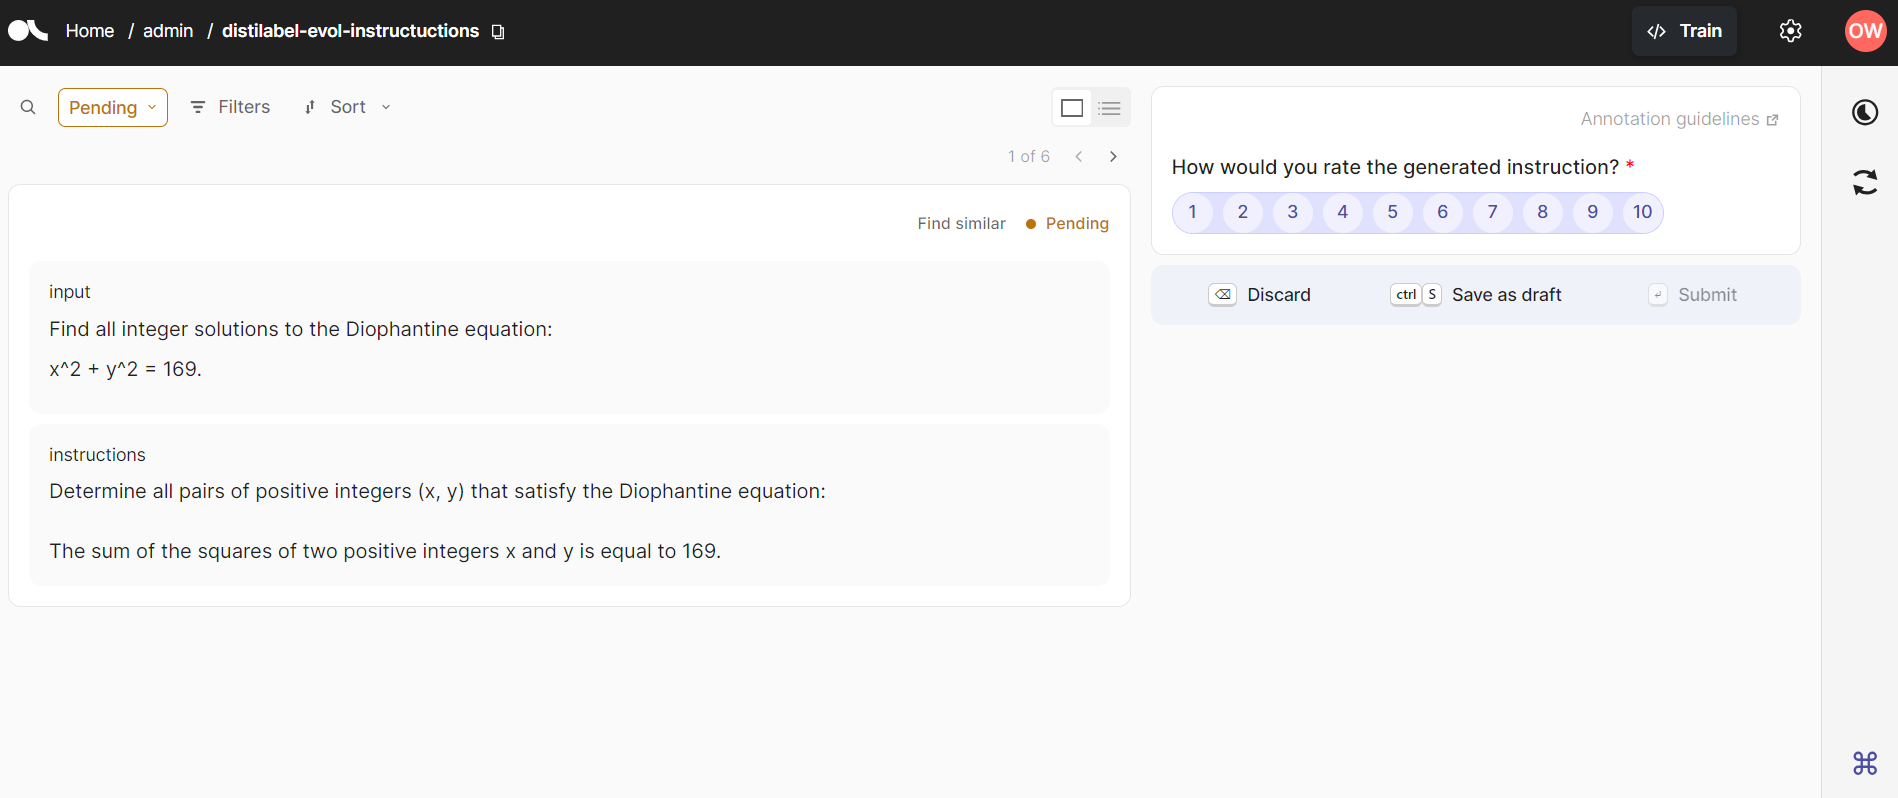

## Generate the responses

Finally, once we have the human feedback for our evolved instructions, we can generate the answers to the evolved instructions. First, we will prepare the dataset to be used in this next step.

If you submitted some feedback in the previous step, we will use only those instructions with a higher rate than the threshold set. If not, you can use the dataset as it is from HuggingFace.

In [55]:
try:
    # Load the dataset from Argilla
    rg_feedback_dataset = rg.FeedbackDataset.from_argilla("distilabel-evol-instructions", workspace="admin")
    
    inputs_set = set()
    threshold = 7

    for record in rg_feedback_dataset.records:
        high_rating_responses = [
            response for response in record.responses
            if response.status == "submitted" and response.values["instruction-rating"].value >= threshold
        ]
        if high_rating_responses:
            inputs_set.add(record.fields['instructions'])
            
    instructions_dataset = Dataset.from_dict({"input": list(inputs_set)})
    
except:
    # Load the dataset from Hugging Face
    rg_feedback_dataset = load_dataset("argilla/distilabel-evol-instructions")
    instructions_dataset = Dataset.from_dict({"input": rg_feedback_dataset['train']['instructions']})

In [87]:
instructions_dataset

Dataset({
    features: ['input'],
    num_rows: 6
})

As outlined in Section 3.2 of the paper, we will employ the same LLM and use the instruction directly as the input prompt. To achieve this, we will utilize the `TextGenerationTask`. Although this task incorporates a predefined system prompt, we consider it appropriate for our scenario. It does not negatively impact the outcome; in fact, employing it aligns with best practices and improves the given answer.

In [95]:
# Define our LLM
response_llm = OpenAILLM(
    task=TextGenerationTask(),
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-3.5-turbo",
    num_threads=4,
    max_new_tokens=2048,
    temperature=1,
    frequency_penalty=0.0,
    top_p=0.9,
)

In [5]:
# Example of the generated prompt
task = TextGenerationTask()
task.generate_prompt(["What's a good way to make a pancake?"])

Prompt(system_prompt="You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.", formatted_prompt=["What's a good way to make a pancake?"])

Now, we can create the pipeline and run it to generate the final dataset.

In [96]:
# Set the pipeline
response_pipe = Pipeline(generator=response_llm)

# Generate the responses
start = time.time()
evol_instruct_dataset = response_pipe.generate(instructions_dataset, batch_size=8)
end = time.time()
print("Elapsed", end - start)

In [105]:
evol_instruct_dataset[0]

{'input': 'Determine all pairs of positive integers (x, y) that satisfy the Diophantine equation:\n\nThe sum of the squares of two positive integers x and y is equal to 169.',
 'generation_model': ['gpt-3.5-turbo'],
 'generation_prompt': [[{'content': '', 'role': 'system'},
   {'content': 'Determine all pairs of positive integers (x, y) that satisfy the Diophantine equation:\n\nThe sum of the squares of two positive integers x and y is equal to 169.',
    'role': 'user'}]],
 'raw_generation_responses': ["We are given that the sum of the squares of two positive integers x and y is equal to 169. In other words, we have the equation:\n\nx^2 + y^2 = 169\n\nTo determine all pairs of positive integers (x, y) that satisfy this equation, we can use a systematic approach. \n\nWe notice that 169 is a perfect square, since it can be written as 13^2. Therefore, we can rewrite the equation as:\n\nx^2 + y^2 = 13^2\n\nNow, let's consider the possible values for x and y. Since we are looking for posit

Finally, we can push the dataset to HuggingFace to share it with the community thanks to the `push_to_hub` method or provide human feedback for the generated answers converting the dataset to a `FeedbackDataset` and pushing it to Argilla.

In [ ]:
# Push to Hugging Face
HF_REPO_ID = "argilla/distilabel-evol-instruct-dataset"
evol_instruct_dataset.push_to_hub(
        HF_REPO_ID,  # type: ignore
        split="train",
        private=False,
        token=os.getenv("HF_TOKEN", None),
    )

In [ ]:
# Push to Argilla
try:
    rg.init(
        workspace="admin",
        extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"}
    )
    rg_evol_instruct_dataset = evol_instruct_dataset.to_argilla()
    rg_evol_instruct_dataset.push_to_argilla(
            name="distilabel-evol-instruct-dataset",
            workspace="admin",
        )
except Exception as e:
    print(e)

## Conclusions

In this tutorial, we followed the method from "WizardLM: Empowering Large Language Models to Follow Complex Instructions" to develop an evolved-instruction dataset. Using `distilabel`, we generated and evaluated new instructions, creating a dataset featuring successful new instructions. Optionally, we employed Argilla to verify the quality of these instructions. Ultimately, we produced responses to the evolved instructions, culminating in a brand-new dataset.

We hope you found this tutorial helpful! 👐

Explore different ways to create new datasets by checking out these tutorials!

* [Clean an existing preference dataset](https://distilabel.argilla.io/latest/tutorials/clean-preference-dataset-judgelm-gpt.html)
* [Create a mathematical preference dataset](https://distilabel.argilla.io/latest/tutorials/create-a-math-preference-dataset.html)